0.6818181818181818


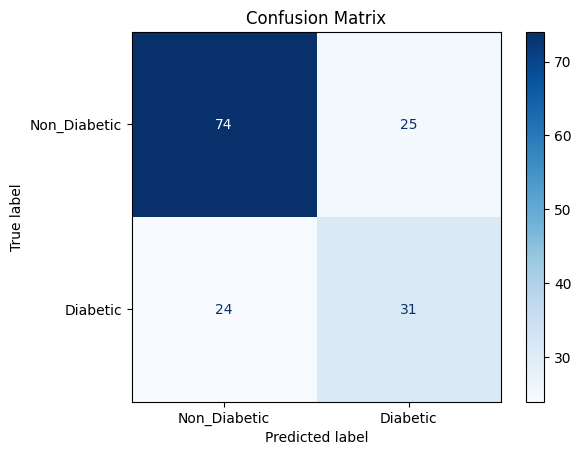

In [ ]:
#import sklearn as sk  
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

np.random.seed(2024)
diabetes = pd.read_csv('diabetes_preprocessed.csv')

y = diabetes.get('Outcome').values
X = diabetes.drop(axis='columns', columns ='Outcome').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

#print(X)
#print(y)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) # accuracy score using a single decision tree
# >>> ca. 0.688
print(accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non_Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

0.7662337662337663


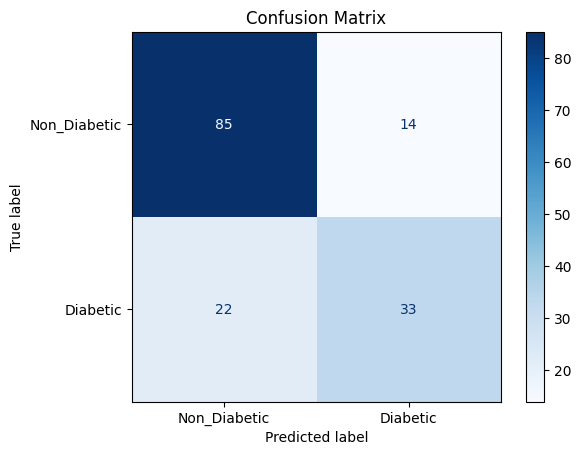

In [89]:
from sklearn import ensemble as en

random_forest = en.RandomForestClassifier()

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) 
print(accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non_Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
